In [2]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import *
from invariance_functions import *
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [4]:

time_step = 0.01
training_time = 0.12
testing_time = 1

max_x = 150
max_v = 30


In [21]:

def energy(X):
    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])

mean = ZeroMean(2)
data_eff_moi = []
data_eff_moi_trac = []

test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))

test_starting = (test_starting_position, test_starting_velocity)
time_setting = (testing_time, time_step)

for n_train in [1, 2, 5, 10]:
    train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
    train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

    print(train_starting_position)
    print(train_starting_velocity)
    data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

    moi, *dump = get_GPR_model(get_MOI(), mean, data, 500)
    print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
    jitter = 5e-4
    invar_density = 40
    invar_range = 3
    dynamics = pendulum_dynamics 

    if n_train == 1:
        kernel = get_invariance_kernel(PendulumInvariance, invar_range, invar_density, jitter) #switch
        known, *dump = get_GPR_model(kernel, mean, data, 500)
        evaluate_invariance = evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
        data_eff_inv = evaluate_invariance[0]

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)


    data_eff_moi.append(evaluate_moi[0])
    data_eff_moi_trac.append(evaluate_moi)

    


[142.5730441]
[24.46178209]
moi:94.78
[-42.42669866  89.87395432]
[11.59381761 -3.33426866]
moi:193.84
[-63.44111836 -82.25790365 117.12919743 120.86159588 132.08113627]
[  9.62602852 -28.5339333  -22.03836328  15.92163115   2.91686232]
moi:520.04
[ -41.12285966 -149.91980115  126.41125227  -10.06868715  104.27485529
   50.63811814  118.05455641  -50.63903505  -21.18529128  -45.76589857]
[-20.61622913  21.69980265   3.79933632 -21.5589938   29.0236635
  18.91849867  -4.51751852 -15.95797681 -23.39229962  -9.34348434]
moi:1091.31


In [3]:
data_eff_inv

0.002983801815028728

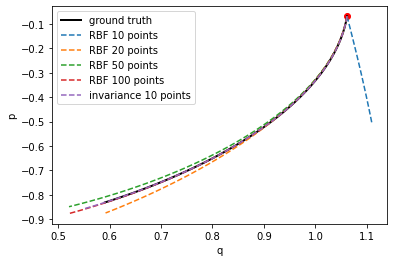

In [23]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
#plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(data_eff_moi_trac[0][1][:,0],data_eff_moi_trac[0][1][:,1], "--", label='RBF 10 points')
plt.plot(data_eff_moi_trac[1][1][:,0],data_eff_moi_trac[1][1][:,1], "--", label='RBF 20 points')
plt.plot(data_eff_moi_trac[2][1][:,0],data_eff_moi_trac[2][1][:,1], "--", label='RBF 50 points')
plt.plot(data_eff_moi_trac[3][1][:,0],data_eff_moi_trac[3][1][:,1], "--", label='RBF 100 points')
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="invariance 10 points")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/data_efficiency.pdf")